# Basic SOM
*implementation from [Sachin Joglekar's blog](https://codesachin.wordpress.com/2015/11/28/self-organizing-maps-with-googles-tensorflow/)*

<div class='alert alert-block alert-info'>Please, keep in mind that the original code that has been linked above was written with tensorflow v.0. The python3 code in this notebook has been updated to tensorflow v. 1.4.0. It will not work with older versions.</div>

We go over the basic SOM implementation step by step.    
First, the used modules are imported:

In [1]:
import tensorflow as tf    
import numpy as np

## Class SOM

The **class SOM** represents the self-organizing map and is defined with the following parameters:    
-  **m, n**: &nbsp; dimensions of the SOM
-  **dim**: &nbsp; dimentionality of the current training iteration
-  **n_iterations**: &nbsp; number of training iterations
-  **alpha**: &nbsp; learning rate (default: 0.3)
-  **sigma**: &nbsp; radius of the *best matching unit* (BMU), used as the neighbourhood value (default: max(m,n)/2.0)    

As the dataflow structure, a TensorFlow graph **_graph** is used.    
The initialization is as follows. The variable **_trained** indicates if the SOM has been trained:

In [2]:
class SOM(object):
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        self._m = m
        self._n = n
        self._dim = dim
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
        
        self._graph = tf.Graph()

We can now create a **SOM** object and for example assign the dimensions 20x30, the dimentionality of 3 and 400 iterations:

In [3]:
som = SOM(20,30,3,400)

## Methods of SOM    
The **SOM** object requires some methods we will introduce one after another. 

-  **_neuron_locations**    
yields the 2-D locations of the individual neurons in the SOM one by one:

In [4]:
def _neuron_locations(self,m,n):
    for i in range(m):
        for j in range(n):
            yield np.array([i,j])

-  **train**    
trains the SOM for *n_iterations* iterations    
the weight vectors are adjusted with each iteration, and finally, they are stored in *_centroid_grid*:
<a id='train'></a>

In [5]:
def train(self, input_vects):
    for iter_no in range(self._n_iterations):
        for input_vect in input_vects:
            self._sess.run(self._training_op, feed_dict={self._vect_input: input_vect, self._iter_input: iter_no}) # update weights
 
    centroid_grid = [[] for i in range(self._m)] # one array for each line in SOM (size m)
    self._weightages = list(self._sess.run(self._weightage_vects)) # list of weight vectors, starting with the upper left one
    self._locations = list(self._sess.run(self._location_vects)) # list of the corresponding locations [x,y]
    
    for i, loc in enumerate(self._locations):
        centroid_grid[loc[0]].append(self._weightages[i])
    self._centroid_grid = centroid_grid # contains one array per line in SOM, each holding weight vectors of that particular line
 
    self._trained = True

-  **get_centroids**    
returns the centroid grid obtained by the training method [train()](#train)

In [6]:
def get_centroids(self):
    if not self._trained:
        raise ValueError("SOM not trained yet")
    return self._centroid_grid

-  **map_vects**    
maps each input vector to the relevant neuron in the SOM grid

In [7]:
def map_vects(self, input_vects):
    if not self._trained:
        raise ValueError("SOM not trained yet")
 
    to_return = []
    for vect in input_vects:
        min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect - self._weightages[x]))
        to_return.append(self._locations[min_index])
 
    return to_return    

-  **init_graph**    
Finally, we define the method **init_graph()**, which initializes the previously created graph with its operations and tensors.    
<font color=grey>The initialization was originally part of the class costructor. For the purposes of a step by step execution, it is split and moved here.</font>

> The following data is stored in the <font color=green>class SOM</font>:
-  **_weightage_vects**: weight vectors of the units, each of dimentionality *dim*, stored in a matrix of the size [m*n,3]
-  **_location_vects**: SOM grid location of the units, stored as coordinates x,y in a matrix of the size [m*n, 2]
-  **_vect_input**: training vector
-  **_iter_input**: iteration number

> The following data is calculated during the <font color=green>training</font>:    
-  **bmu_index**: index of the *best matching unit*, based on the Euclidean distance between the unit's weight vector and the input
-  **bmu_loc**: location of the *best matching unit*, based on its index
-  **learning_rate_op**: learning rate operation
-  **_alpha_op**: learning rate, decreasing with each iteration
-  **_sigma_op**: neighbourhood radius, decreasing with each iteration
-  **bmu_distance_squares** Manhattan distance from the BMU
-  **neighbourhood_func** neighbourhood operation: $e^{(-bmu\_dist/sigma)}$
<a id='init_graph'></a>

In [8]:
def init_graph(self):
    self._graph = tf.Graph()
    with self._graph.as_default(): # declare as the default graph of the current thread
        self._weightage_vects = tf.Variable(tf.random_normal([self._m*self._n, self._dim])) # weight vectors with random values
        self._location_vects = tf.constant(np.array(list(self._neuron_locations(self._m, self._n)))) # SOM grid location
        self._vect_input = tf.placeholder("float", [self._dim]) # training vector
        self._iter_input = tf.placeholder("float") # iteration number
        
        # operations of the training procedure...
        # BMU index
        bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, tf.stack(
                    [self._vect_input for i in range(self._m*self._n)])), 2), 1)),0)
        
        # BMU location as [x y]
        slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0,1]]))
        bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,tf.constant(np.array([1, 2]))),[2])
        
        # learning rate
        learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input, self._n_iterations)) # 1-(current iteration / number iterations)
        _alpha_op = tf.multiply(self.alpha, learning_rate_op) # default alpha * decreasing learning rate
        _sigma_op = tf.multiply(self.sigma, learning_rate_op) # default sigma * decreasing learning rate
        
        # neighbourhood
        bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(self._location_vects, tf.stack([bmu_loc for i in range(self._m*self._n)])), 2), 1)
        neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
        
        # operations for the update on weight vectors
        # new weight = old weight + delta, where delta = lrm * (input vector - current weight vector)
        learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
        learning_rate_multiplier = tf.stack([tf.tile(tf.slice(learning_rate_op, np.array([i]), np.array([1])), [self._dim]) for i in range(self._m*self._n)])
        weightage_delta = tf.multiply(learning_rate_multiplier,
                            tf.subtract(tf.stack([self._vect_input for i in range(self._m*self._n)]),self._weightage_vects))                                         
        new_weightages_op = tf.add(self._weightage_vects, weightage_delta)
        self._training_op = tf.assign(self._weightage_vects, new_weightages_op) # update weight vectors (weight vector + delta)
        
        # session initialization
        self._sess = tf.Session()
        
        # global variable initialization
        init_op = tf.global_variables_initializer()
        self._sess.run(init_op)

The described methods are added to the instance of **SOM** retrospectively, like in the following example:

## Example - Colour clustering:    
In this example, some colours are supposed to be clustered and organized in the map, according to their RGB values and their names. The resulting SOM clustering is visible at the bottom of the cell.

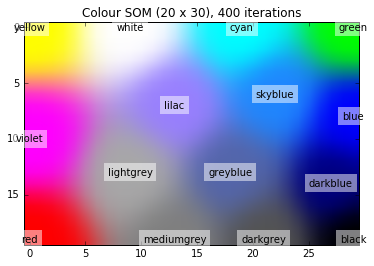

In [9]:
import types # for the retrospective inclusion of methods to a class instance
from matplotlib import pyplot as plt # for plotting the images
%matplotlib inline
 
# training inputs for RGBcolours
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']
 
#train a 20x30 SOM with 400 iterations
som = SOM(20, 30, 3, 400)

# add class methods to the SOM object
som._neuron_locations = types.MethodType(_neuron_locations,som)
som.train = types.MethodType(train,som)
som.get_centroids = types.MethodType(get_centroids,som)
som.map_vects = types.MethodType(map_vects,som)
som.init_graph = types.MethodType(init_graph,som)

# init graph and train
som.init_graph()
som.train(colors)
 
# get output grid
image_grid = som.get_centroids()
 
# map colours to their closest neurons
mapped = som.map_vects(colors)

# plot
plt.imshow(image_grid)
plt.title('Colour SOM (' + str(som._m) + ' x ' + str(som._n) + '), ' + str(som._n_iterations) + ' iterations')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

By running the session created in the method [init_graph()](#init_graph), we can evaluate the tensors and display the SOM data, for example the **weight vectors**:

In [10]:
#np.set_printoptions(threshold=np.inf) # <--- with this option, the entire array is printed (we do not wish it here)
print(som._sess.run(som._weightage_vects))

[[  9.99999106e-01   9.99900520e-01   4.13632515e-04]
 [  9.99997020e-01   9.99763727e-01   2.29197950e-03]
 [  9.99973238e-01   9.99202251e-01   1.86149590e-02]
 ..., 
 [  1.04223881e-02   1.04533900e-02   4.72232364e-02]
 [  1.30293181e-03   1.30658539e-03   1.52993901e-02]
 [  1.96982422e-04   1.97605201e-04   5.61508210e-03]]


The corresponding **locations** of the vectors can be displayed by using the same session:

In [11]:
print(som._sess.run(som._location_vects))

[[ 0  0]
 [ 0  1]
 [ 0  2]
 ..., 
 [19 27]
 [19 28]
 [19 29]]


<center><div class='alert alert-block alert-info'>188.413 *Self-organizing Systems*, TU Wien, WS2017, GR05</div></center>